# IC50 exploration

This notebook demonstrates how to process plates associated to the paper [A SARS-CoV-2 cytopathicity dataset generated by high-content screening of a large drug repurposing collection](https://doi.org/10.1038/s41597-021-00848-4).
We explore the metadata linked to [idr0094-ellinger-sarscov2/screenB](http://idr.openmicroscopy.org/webclient/?show=screen-2603).

## Collect parameters

In [92]:
# Parameters:
screenId = 2603


In [93]:
# Load the libraries
library(romero.gateway)
library(dplyr)

## Connect to IDR

In [94]:
server <- OMEROServer(host = 'wss://idr.openmicroscopy.org/omero-ws', port = 443L, username='public', password='public')
server <- connect(server)
paste('Successfully logged in as', server@user$getUserName())

[1] "Successfully logged in as public"

## Load the metadata associated to the study

In [95]:
tableName <- 'bulk_annotations'

### Load the annotations as R-Dataframes
Due to the size of the table, this could take few minutes.

In [98]:
screen <- loadObject(server, "ScreenData", screenId)

annos <- getAnnotations(server, 'ScreenData', getOMEROID(screen), nameFilter = tableName)
annotationFileID = as.integer(annos$FileID)

df <- loadDataframe(screen, annotationFileID)
df

Plate,Well,Characteristics [Organism 1],Term Source 1 REF,Term Source 1 Accession,Characteristics [Organism 2],Term Source 2 REF,Term Source 2 Accession,Characteristics [Cell Line],Term Source 3 REF,⋯,Control Type,Quality Control,Channels,Compound Concentration (microMolar),Percentage Inhibition (DPC),Cells - Number of Objects,Hit Compound (over 75% activity),Phenotype Annotation Level,Plate Name,Well Name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560940),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,54.9,19819,Yes,well level,ESP0025712,a1
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560905),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,70.28,23010,Yes,well level,ESP0025712,a2
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560897),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,73.25,23627,Yes,well level,ESP0025712,a3
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560924),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,0.56,8544,Yes,well level,ESP0025712,a4
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560856),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,-3.4,7723,Yes,well level,ESP0025712,a5
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560847),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,38.08,16329,Yes,well level,ESP0025712,a6
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560899),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,12.96,11116,Yes,well level,ESP0025712,a7
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560862),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,42.41,17228,Yes,well level,ESP0025712,a8
omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560927),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,61.74,21238,Yes,well level,ESP0025712,a9


## Rename the columns to simplify exploration
The columns are renamed to simplify data access.

In [100]:
names(df)[names(df) == 'Compound Name'] <- "CompoundName"
names(df)[names(df) == 'Compound InChIKey'] <- 'InChIKey'
names(df)[names(df) == 'Compound Concentration (microMolar)'] <- "Concentration"
names(df)[names(df) == 'Percentage Inhibition (DPC)'] <- "Inhibition"

,Plate,Well,Characteristics [Organism 1],Term Source 1 REF,Term Source 1 Accession,Characteristics [Organism 2],Term Source 2 REF,Term Source 2 Accession,Characteristics [Cell Line],Term Source 3 REF,⋯,Control Type,Quality Control,Channels,Concentration,Inhibition,Cells - Number of Objects,Hit Compound (over 75% activity),Phenotype Annotation Level,Plate Name,Well Name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560940),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,54.9,19819,Yes,well level,ESP0025712,a1
2,omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560905),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,70.28,23010,Yes,well level,ESP0025712,a2
3,omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560897),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,73.25,23627,Yes,well level,ESP0025712,a3
4,omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560924),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,0.56,8544,Yes,well level,ESP0025712,a4
5,omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560856),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,-3.4,7723,Yes,well level,ESP0025712,a5
6,omero.gateway.model.PlateData (id=7815),omero.gateway.model.WellSampleData (id=1560847),Homo sapiens,NCBITaxon,NCBITaxon_9606,Severe acute respiratory syndrome coronavirus 2,NCBITaxon,NCBITaxon_2697049,Caco-2,EFO,⋯,,pass,cell body,20,38.08,16329,Yes,well level,ESP0025712,a6


## Filter by compound
First copy the data frame and filter using the compound name the data on the copied on the data frame.
Convert the value into numerical values.

In [17]:
compoundName <- "Remdesivir"
inChIKey <- "RWWYLEGWBNMMLJ-YSOARWBDSA-N"

In [18]:
filter_data <- function(df, value) {
    dfcopy <- cbind(df)
    dfcopy <- filter(dfcopy, CompoundName == value)
    
    df1 <- subset(dfcopy, select=c("Concentration", "Inhibition"))
    df1 <- df1[c("Inhibition", "Concentration")]
    data <- mutate_all(df1, function(x) as.numeric(as.character(x)))
}

In [19]:
data <- filter_data(df, compoundName)
nrow(data)

[1] 24

## Calculate the half maximal inhibitory concentration IC50

The half maximal inhibitory concentration (IC50) is a measure of the potency of a substance in inhibiting a specific biological or biochemical function. IC50 is a quantitative measure that indicates how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%.

In [83]:
calculate_IC50 <- function(data){
  sortedX = sort(data[,2])
  sortedY = sort(data[,1])
  lx <- log10(sortedX)
  xx <- lx * lx
  xy <- lx * sortedY
  sumx <- sum(lx)
  sumy <- sum(sortedY)
  sumxx <- sum(xx)
  sumxy <- sum(xy)
  sizexy <- length(xy) 
  M <- (sumxy*sizexy - sumx*sumy)/(sumxx*sizexy-sumx*sumx)
  N <- (sumy- M*sumx)/sizexy
  lowerBound <- min(sortedY)
  upperBound <- max(sortedY)

  IC50 <- 10^(((lowerBound + upperBound)/2-N)/M)
  Hill <- sign(M)
  Fit <- lowerBound + ((upperBound - lowerBound )/(1+((IC50/sortedX)^Hill)))
  res <- sortedY -Fit
  returned_values <- list("ic50" = IC50, "fit" = Fit, "response" = sortedY, "lx" = lx)
  return(returned_values)
}

In [84]:
values <- calculate_IC50(data)
IC50 <- values$ic50
IC50

[1] 0.489774

## Plot the Dose Response curve 

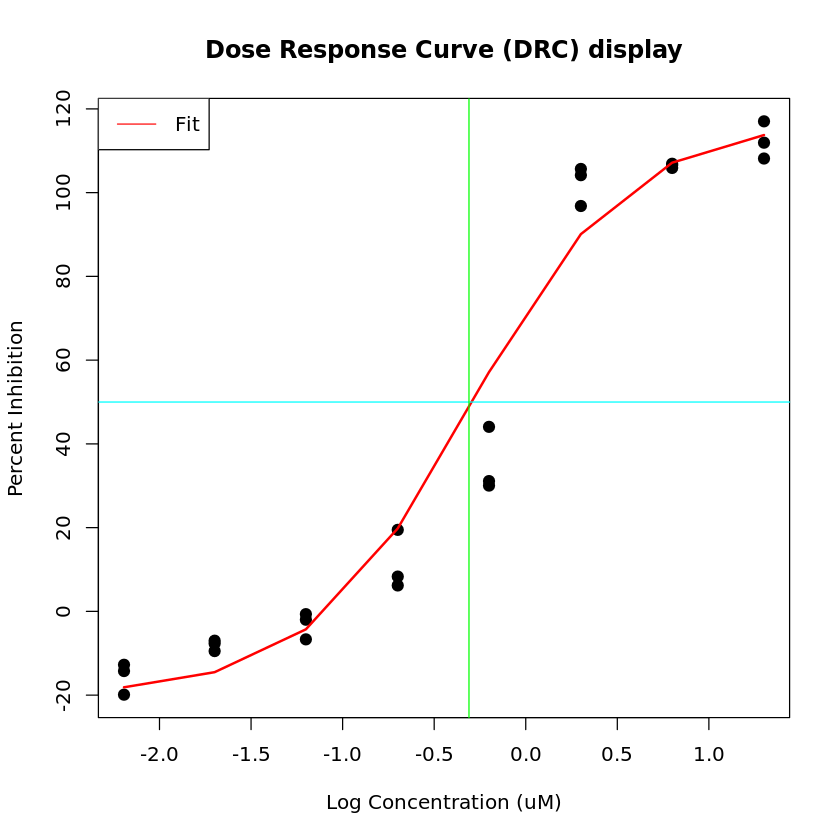

In [86]:
plot(values$lx, values$response,
     main = "Dose Response Curve (DRC) display",
     xlab = "Log Concentration (uM)",
     ylab = "Percent Inhibition", pch=20, lwd=5)
lines(values$lx, values$fit, col="red", pch=5, lwd=2)
abline(h = 50, col = "cyan")
abline(v = log10(IC50), col = "green")
legend("topleft", legend=c("Fit"),
       col=c("red"), lty = 1:2, cex=1)

## Determine IC50 for each compound

For each unique compound, determine the IC50.

In [28]:
compounds <- unique(as.vector(df["CompoundName"]))

In [29]:
ic <- vector()
cn <- vector()
for(i in 1:nrow(compounds)) {
    c <- compounds[i,]
    if (c != "") {
      d <- filter_data(df, c)
      results <- calculate_IC50(d)
      ic <- c(ic, results$ic50)
      cn <- c(cn, c) 
    }
}

result <- data.frame(cn, ic)
x <- c("Compound Name", "IC50 (uM)")
colnames(result) <- x
result

Compound Name,IC50 (uM)
<fct>,<dbl>
Loratadine,281.24736974
Lidoflazine,403.25182941
MBX-2982,27.48989184
Algestone-acetophenide,2.98306942
Octenidine dihydrochloride,248.87303087
Alvocidib,2.22993604
PD-161570,0.50274874
PFK-015,131.76981723
DCPIB,203.70664375


## Export result as CSV

Write the calculated IC50 result into a CSV file. The CSV file is first created in the ``home`` directory. The CSV file can then be downloaded to your local machine. To download it, click ``File > Open``, navigate to the ``home`` directory (click onto the folder icon in top-left corner), select the CSV file and open it, then click ``File > Download``.

In [30]:
setwd(path.expand('~'))
write.csv(result, "ic50.csv")

## Close the connection to the server 

In [18]:
disconnect(server)

### License

Copyright (C) 2021 University of Dundee. All Rights Reserved. This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA. 